# Introducción

Este notebook desarrolla el análisis exploratorio de datos (EDA) sobre un conjunto de pólizas de autos y sus reclamos, con información de cliente, vehículo y equipamiento de seguridad. El objetivo es entender la estructura del portafolio y la variable objetivo claim_status antes de construir modelos predictivos de probabilidad de siniestro.



# Objetivo

Evaluar la calidad y consistencia de los datos (tipos, rangos, desbalance de la variable objetivo y presencia de valores atípicos o identificadores sin valor analítico como policyid).

Describir cómo se distribuyen los clientes y vehículos por región, segmento, modelo, tipo de motor y nivel de seguridad.

Identificar qué variables muestran mayor asociación con claim_status y qué segmentos presentan tasas de siniestralidad significativamente distintas de la línea base global.

# Metodología

Preparación de datos: carga del CSV original, estandarización de nombres, eliminación de identificadores, tipificación de variables numéricas, categóricas y binarias, y verificación de rangos lógicos.

Análisis univariado: conteos y gráficos interactivos (barras e histogramas) para variables categóricas y numéricas, junto con el cálculo de la tasa global de siniestros y del grado de desbalance entre casos con y sin reclamo.
​
Análisis bivariado con el target: boxplots, histogramas segmentados y perfiles de riesgo por categoría (por ejemplo, regioncode, segment, fuel_type, ncap_rating) comparando cada grupo contra la línea base de siniestralidad.
​
Correlaciones: cálculo de la matriz de correlaciones Phi‑K para combinar variables numéricas, categóricas y binarias en una misma escala 0–1, y selección de las variables más asociadas a claim_status como insumo para el modelado posterior.

# Instalación e importación de librerías

In [1]:
!pip install -r requirements.txt -qq

In [3]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pandas.api.types import is_numeric_dtype
import phik
from phik.report import plot_correlation_matrix
import plotly.io as pio
pio.renderers.default = "png"

# Importación de datos y transformación de datos

In [4]:
datos = pd.read_csv('/content/Claims Dataset.csv', sep=';')
df = datos.copy()

In [5]:
from Utils import extraer_motor_metricas, binarizar_columnas

In [6]:
df = extraer_motor_metricas(df, 'max_torque', 'max_torque_nm', 'max_torque_rpm')
df = extraer_motor_metricas(df, 'max_power', 'max_power_bhp', 'max_power_rpm')

In [7]:
columns = ['is_esc',	'is_adjustable_steering',	'is_tpms',	'is_parking_sensors',	'is_parking_camera',
           'is_front_fog_lights',	'is_rear_window_wiper',	'is_rear_window_washer',	'is_rear_window_defogger',
           'is_brake_assist',	'is_power_door_locks',	'is_central_locking',	'is_power_steering',
           'is_driver_seat_height_adjustable',	'is_day_night_rear_view_mirror',	'is_ecw',	'is_speed_alert'
]

df = binarizar_columnas(df, columns)

In [9]:
print("Shape:", df.shape)
print("\nTipos:\n", df.dtypes)

Shape: (58592, 43)

Tipos:
 policy_id                            object
subscription_length                 float64
vehicle_age                         float64
customer_age                          int64
region_code                          object
region_density                        int64
segment                              object
model                                object
fuel_type                            object
engine_type                          object
airbags                               int64
is_esc                                int64
is_adjustable_steering                int64
is_tpms                               int64
is_parking_sensors                    int64
is_parking_camera                     int64
rear_brakes_type                     object
displacement                          int64
cylinder                              int64
transmission_type                    object
steering_type                        object
turning_radius                      float64
leng

## Validación de nulos

In [10]:
null_cnt = df.isna().sum().sort_values(ascending=False)
null_pct = (null_cnt / len(df) * 100).round(3)
null_report = pd.DataFrame({"null_cnt": null_cnt, "null_pct": null_pct})
print(null_report[null_report["null_cnt"] > 0].head(50))

Empty DataFrame
Columns: [null_cnt, null_pct]
Index: []


No se evidencia la presencia de valores nulos ni faltantes

## Validación de duplicidad por ID

In [11]:
if "policy_id" in df.columns:
    n_unique = df["policy_id"].nunique(dropna=False)
    print("policy_id únicos:", n_unique, "de", len(df), "filas")
    if n_unique < len(df):
        print("ALERTA: policy_id repetidos:", len(df) - n_unique)

policy_id únicos: 58592 de 58592 filas


Los Identificadores de policy_id son identificadores unicos sin valores repetidos.

## Validación de rangos

In [12]:
print("\n=== 4) Describe numéricas (sanity de rangos) ===")
num = df.select_dtypes(include=[np.number])
desc = num.describe(percentiles=[.01, .05, .5, .95, .99]).T
desc[["min", "1%", "5%", "50%", "95%", "99%", "max"]].sort_values("max", ascending=False).head(50)


=== 4) Describe numéricas (sanity de rangos) ===


,min,1%,5%,50%,95%,99%,max
region_density,290.00,290.00,4076.00,8794.0,73430.00,73430.00,73430.00
max_power_rpm,3600.00,3600.00,4000.00,6000.0,6000.00,6000.00,6000.00
max_torque_rpm,1750.00,1750.00,2750.00,3500.0,4400.00,4400.00,4400.00
length,3445.00,3445.00,3445.00,3845.0,4300.00,4300.00,4300.00
width,1475.00,1475.00,1515.00,1735.0,1790.00,1790.00,1811.00
gross_weight,1051.00,1051.00,1155.00,1335.0,1720.00,1720.00,1720.00
displacement,796.00,796.00,796.00,1197.0,1497.00,1498.00,1498.00
max_torque_nm,60.00,60.00,60.00,113.0,250.00,250.00,250.00
max_power_bhp,40.36,40.36,40.36,88.5,113.45,113.45,118.36
customer_age,35.00,35.00,35.00,44.0,58.00,63.00,75.00


Los rabgos de las variables parecen razonables, sin valores atipicos extremos en su escala. Lo que indica un datset sano en estos termninos.

## Cardinalidad categórica

In [13]:
print("\n=== 6) Cardinalidad categóricas ===")
cat = df.select_dtypes(include=["object", "category"])
card = cat.nunique(dropna=False).sort_values(ascending=False)
print(card.head(30))


=== 6) Cardinalidad categóricas ===
policy_id            58592
region_code             22
model                   11
engine_type             11
segment                  6
fuel_type                3
steering_type            3
rear_brakes_type         2
transmission_type        2
dtype: int64


Como se puede observar en la anterior tabla, la cardinalidad de las variables categoricas no conlleva a una excecisa preocupación por la excesiva dimensionalidad, lo que se traduce en el hecho de que se puedan usar teçnicas como one hot encoding para el procesamiento de las variables.

# Análisis univariado forma y sesgo

In [ ]:
numeric_vars = [
    'subscription_length', 'vehicle_age', 'customer_age',
    'torque_nm', 'power_bhp', 'displacement',
    'length', 'width'
]

numeric_vars = [col for col in numeric_vars if col in df.columns]

print("--- ESTADÍSTICOS DE FORMA (SKEWNESS) ---")
skewness = df[numeric_vars].skew().sort_values(ascending=False)
print(skewness)
print("\nNota: Skewness > 1 indica sesgo positivo fuerte (cola derecha).")
print("Candidatos a transformación Logarítmica: ", skewness[skewness > 1].index.tolist())

--- ESTADÍSTICOS DE FORMA (SKEWNESS) ---
vehicle_age            1.094081
customer_age           0.659786
length                 0.145801
subscription_length    0.053332
displacement          -0.105317
width                 -0.488392
dtype: float64

Nota: Skewness > 1 indica sesgo positivo fuerte (cola derecha).
Candidatos a transformación Logarítmica:  ['vehicle_age']


Valores superiores a 1 en el inidcador reflejan sesgos positivos fuertes o colas hacia la derecha, lo que se hace evidente numericamente con la variable vehicle_age. En graficos subsiguientes se confirmará esto visualmente.

# Análisis gráfico Variables númericas

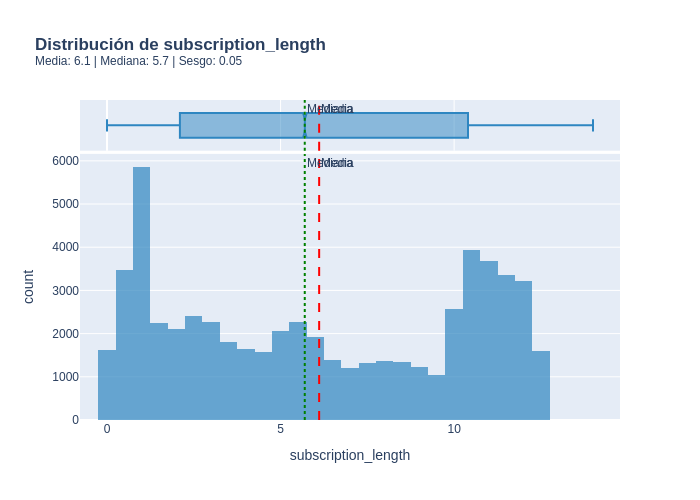

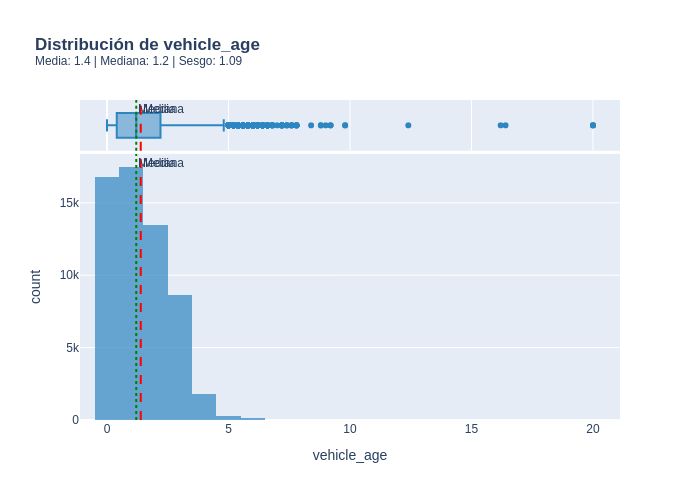

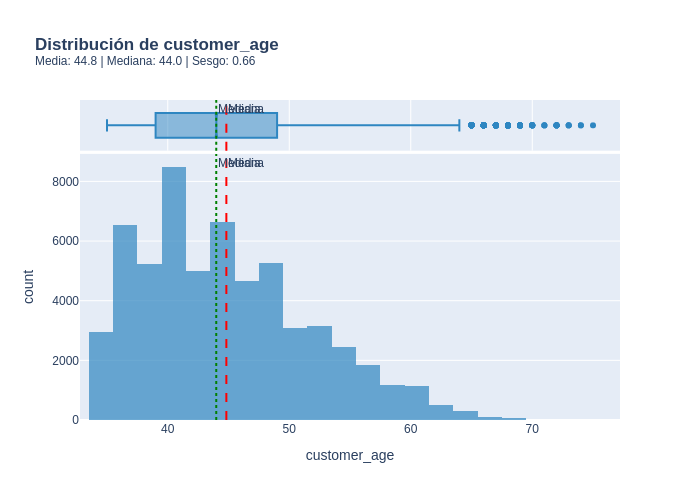

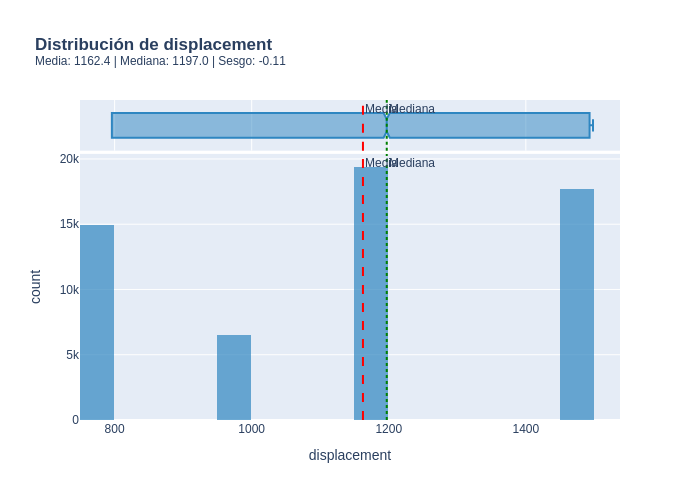

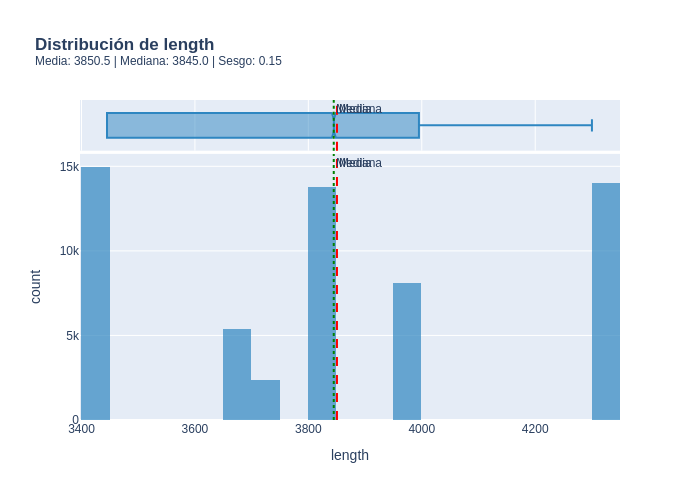

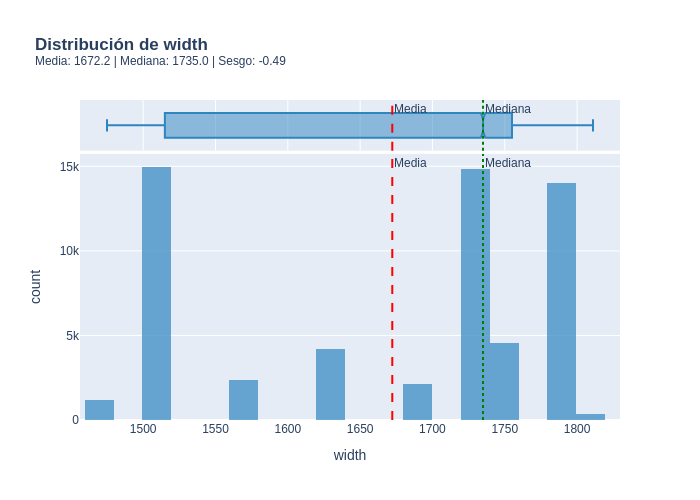

In [15]:
for var in numeric_vars:
    # Calculo media y mediana
    mu = df[var].mean()
    median = df[var].median()

    fig = px.histogram(
        df, x=var,
        nbins=30,
        title=f"<b>Distribución de {var}</b><br><sup>Media: {mu:.1f} | Mediana: {median:.1f} | Sesgo: {df[var].skew():.2f}</sup>",
        marginal="box",
        opacity=0.7,
        color_discrete_sequence=['#2E86C1']
    )

    # Líneas de referencia
    fig.add_vline(x=mu, line_width=2, line_dash="dash", line_color="red", annotation_text="Media")
    fig.add_vline(x=median, line_width=2, line_dash="dot", line_color="green", annotation_text="Mediana")

    fig.show()

Se observamn sesgos positivos o cola a la derecha en las variables subscription_length (fuerte) y customer_age (moderado), por otra parte la variable subcription_lenght muestra un comprtamiento similar a una distribución bimodal, con picos en sus extremos.

# Análisis Univariado Categoricas, frecuencia y cardinalidad


--- CARDINALIDAD Y DOMINANCIA ---
Variable 'region_code': 22 categorías. La Top 1 (C8) cubre el 23.3% de los datos.


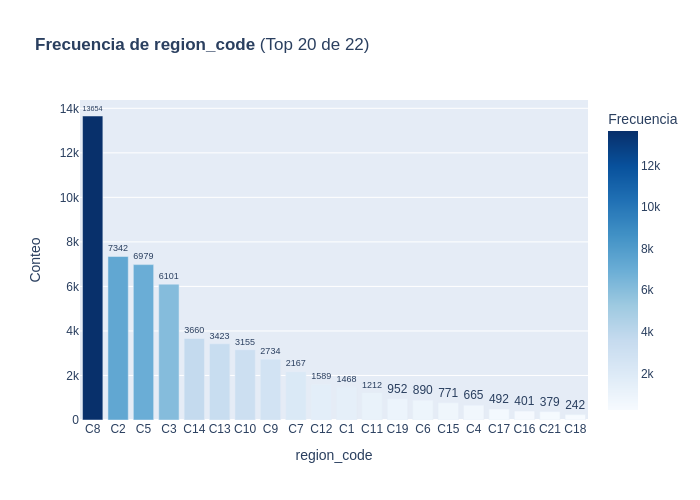

Variable 'segment': 6 categorías. La Top 1 (B2) cubre el 31.3% de los datos.


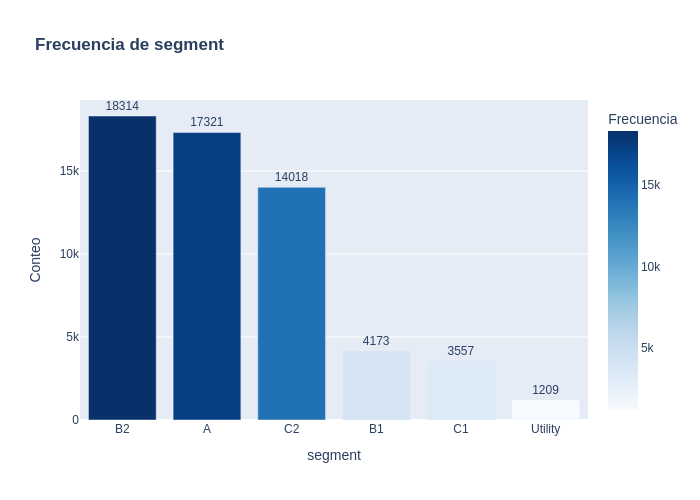

Variable 'model': 11 categorías. La Top 1 (M1) cubre el 25.5% de los datos.


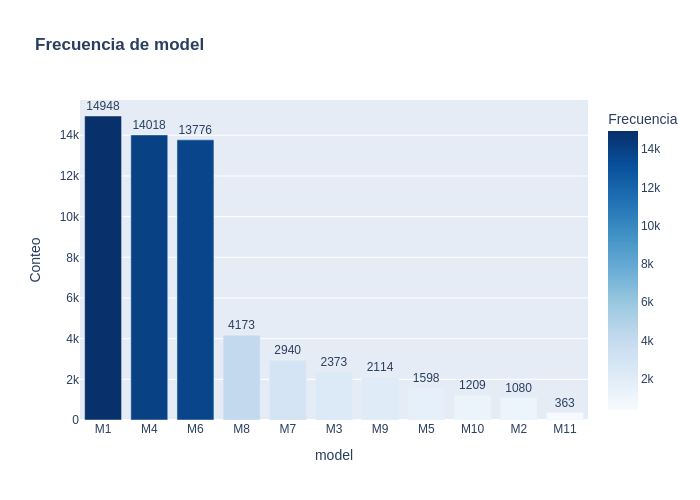

Variable 'fuel_type': 3 categorías. La Top 1 (Petrol) cubre el 35.0% de los datos.


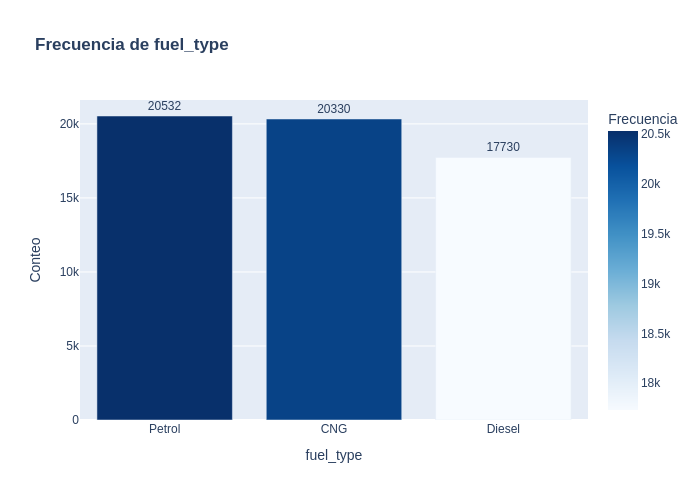

Variable 'engine_type': 11 categorías. La Top 1 (F8D Petrol Engine) cubre el 25.5% de los datos.


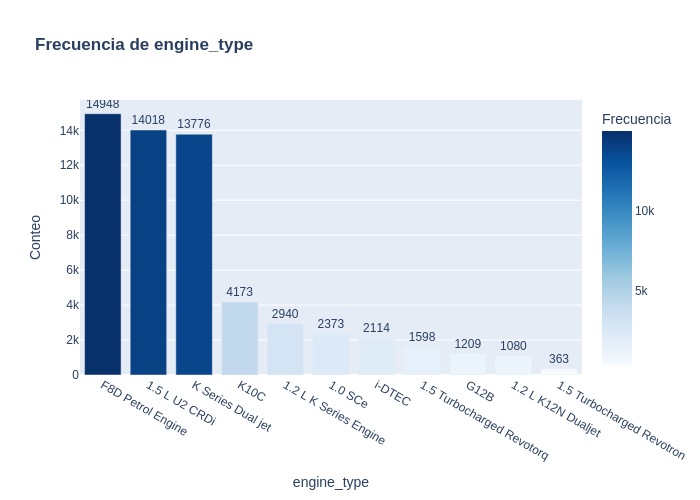

Variable 'rear_brakes_type': 2 categorías. La Top 1 (Drum) cubre el 76.1% de los datos.


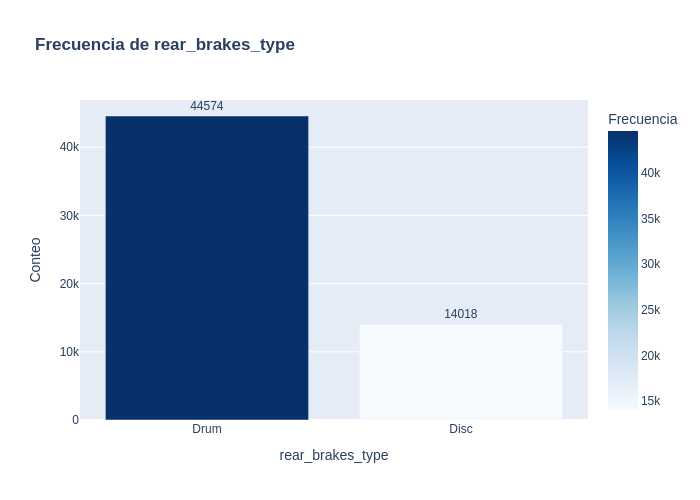

Variable 'transmission_type': 2 categorías. La Top 1 (Manual) cubre el 65.2% de los datos.


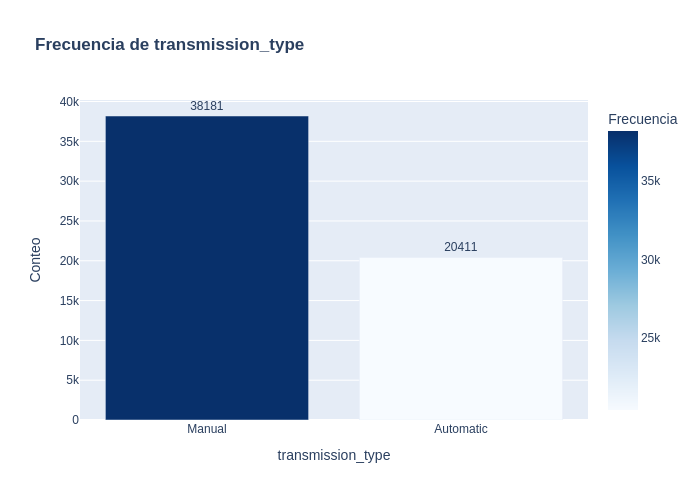

Variable 'steering_type': 3 categorías. La Top 1 (Power) cubre el 57.2% de los datos.


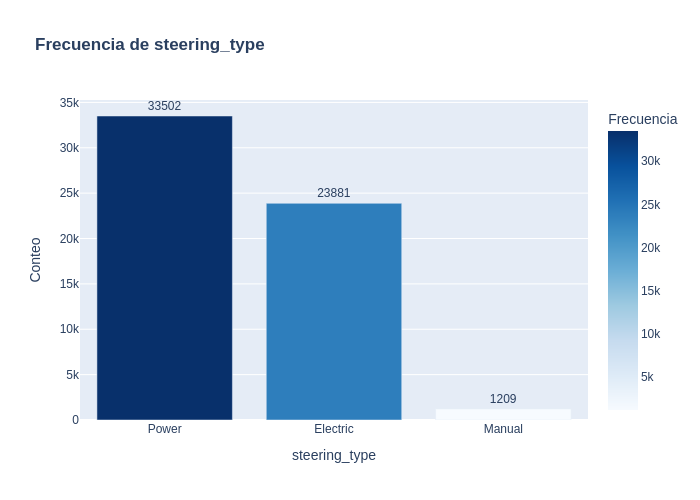

In [16]:
categorical_vars = df.select_dtypes(include=['object', 'category']).columns.tolist()

if 'policy_id' in categorical_vars: categorical_vars.remove('policy_id')

print("\n--- CARDINALIDAD Y DOMINANCIA ---")

# Gráfico de Barras para cada categórica
for var in categorical_vars:
    # Calculo de frecuencias
    counts = df[var].value_counts()
    n_cats = len(counts)
    top_cat_pct = counts.iloc[0] / len(df) * 100

    print(f"Variable '{var}': {n_cats} categorías. La Top 1 ({counts.index[0]}) cubre el {top_cat_pct:.1f}% de los datos.")

    # Top 20 para no romper el gráfico
    if n_cats > 20:
        plot_data = counts.head(20).reset_index()
        title_suffix = f"(Top 20 de {n_cats})"
    else:
        plot_data = counts.reset_index()
        title_suffix = ""

    plot_data.columns = [var, 'Frecuencia']

    fig = px.bar(
        plot_data,
        x=var, y='Frecuencia',
        text='Frecuencia',
        title=f"<b>Frecuencia de {var}</b> {title_suffix}",
        color='Frecuencia',
        color_continuous_scale='Blues'
    )
    fig.update_traces(textposition='outside')
    fig.update_layout(xaxis_title=var, yaxis_title="Conteo")
    fig.show()

Del análisis grafico de las variables categoricaricas y se peude observar predominabncia en el conjunto de datos de las regiones **C8**, **C2**, **C5**, **C3**, **C14**,, **C13**, **C10**, **C9**, **C7**

Los segmentos predominantes son el B2, A2 y C2 respectivamente.

Los modelos M1, M4, M6 representan una muy importante proporción del conjunto de datos frente a los demás modelos.

El tipo de combustible se encuentra muy equilibrado a lo largo del conjunto de datos, siendo el diesel el que presenta una proporción ligeramente más baja.

por tipo de motor, tres motores dominan el conjunto de datos, F8D Petrol Engine, 1.5 L U2 CRDi, K series Dual Jet

Una muy alta proporción maneja frenos de tambor frente a los frenos de disco.

El conjunto de datos revela la predominancia de cajas manuales frente a las automáticas

El tipo de dirección predominante es Powewr, seguido de electrica y muy poca presencia de manual.

## Validación Variables binarias

In [17]:
claims_dist = df['claim_status'].value_counts(normalize=True)
claims_count = df['claim_status'].value_counts()
baseline_rate = df['claim_status'].mean()

print(f"--- ANÁLISIS DE DESBALANCE (PRIORI PROBABILITY) ---")
print(f"Tasa Global de Siniestros (Baseline Risk): {baseline_rate:.2%}")
print(f"Conteo: {claims_count[1]} Siniestros vs {claims_count[0]} No Siniestros")
print(f"Ratio de Desbalance: 1:{round(claims_count[0]/claims_count[1], 1)}")

--- ANÁLISIS DE DESBALANCE (PRIORI PROBABILITY) ---
Tasa Global de Siniestros (Baseline Risk): 6.40%
Conteo: 3748 Siniestros vs 54844 No Siniestros
Ratio de Desbalance: 1:14.6


La tasa global de siniestros es del **6.4%**, presentando un ratio de desbalance 1:15

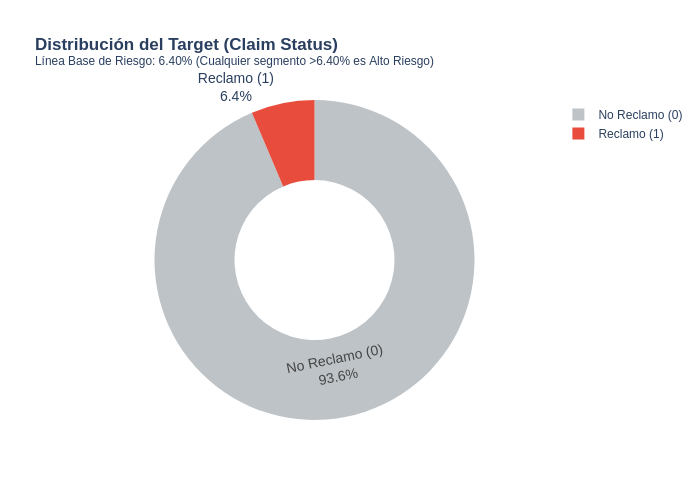

In [18]:
target_df = claims_dist.reset_index()
target_df.columns = ['Status', 'Proportion']
target_df['Label'] = target_df['Status'].map({0: 'No Reclamo (0)', 1: 'Reclamo (1)'})

fig_target = px.pie(
    target_df,
    names='Label',
    values='Proportion',
    title=f"<b>Distribución del Target (Claim Status)</b><br><sup>Línea Base de Riesgo: {baseline_rate:.2%} (Cualquier segmento >{baseline_rate:.2%} es Alto Riesgo)</sup>",
    color='Label',
    color_discrete_map={'No Reclamo (0)': '#BDC3C7', 'Reclamo (1)': '#E74C3C'}, # Gris vs Rojo
    hole=0.5
)
fig_target.update_traces(textinfo='percent+label', textfont_size=14)
fig_target.show()

# Analisis Correlaciones por metodo Phi K

Phi‑K es un coeficiente de correlación entre 0 y 1 que mide la fuerza de relación entre dos variables, sean numéricas, categóricas o binarias, usando tablas de frecuencias y una corrección del chi‑cuadrado. A diferencia de Pearson o Cramér’s V, capta relaciones no lineales y permite comparar todas las parejas de variables en una única escala común, sin cambiar de método según el tipo de dato.



In [19]:
interval_cols = [
    "subscription_length",
    "vehicle_age",
    "customer_age",
    "region_density",
    "displacement",
    "cylinder",
    "turning_radius",
    "length",
    "width",
    "gross_weight",
    "airbags",
    "ncap_rating",
    "max_torque_nm",
    "max_torque_rpm",
    "max_power_bhp",
    "max_power_rpm",
]


categorical_cols = [
    "region_code",
    "segment",
    "model",
    "fuel_type",
    "engine_type",
    "rear_brakes_type",
    "transmission_type",
    "steering_type",
]


binary_cols = [
    "is_esc",
    "is_adjustable_steering",
    "is_tpms",
    "is_parking_sensors",
    "is_parking_camera",
    "is_front_fog_lights",
    "is_rear_window_wiper",
    "is_rear_window_washer",
    "is_rear_window_defogger",
    "is_brake_assist",
    "is_power_door_locks",
    "is_central_locking",
    "is_power_steering",
    "is_driver_seat_height_adjustable",
    "is_day_night_rear_view_mirror",
    "is_ecw",
    "is_speed_alert",
    "claim_status",
]

df_phi = df.copy()
df_phi = df_phi.iloc[:,1:]

df_phi[interval_cols] = df_phi[interval_cols].apply(pd.to_numeric, errors="coerce")

df_phi[categorical_cols] = df_phi[categorical_cols].astype("category")

df_phi[binary_cols] = df_phi[binary_cols].astype("category")

phik_matrix = df_phi.phik_matrix(interval_cols=interval_cols)

phik_target = phik_matrix['claim_status'].sort_values(ascending=False)




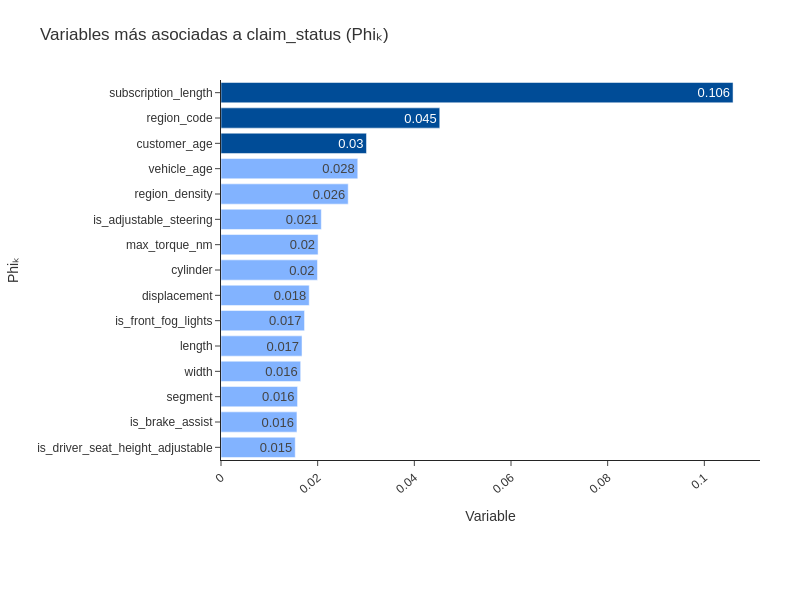

In [20]:
phik_plot = phik_target.iloc[1:].sort_values(ascending=True)
top_n = 15
df_phik = phik_plot.tail(top_n).reset_index()
df_phik.columns = ["variable", "phi_k"]

# Colores
colors = ["#004C97" if i > 11 else "#82B3FF" for i in range(len(df_phik))]

fig = go.Figure(
    go.Bar(
        x=df_phik["phi_k"],
        y=df_phik["variable"],
        marker_color=colors,
        text=df_phik["phi_k"].round(3),
        textposition="auto",
        orientation="h",
        textfont=dict(size=20)
    )
)

fig.update_layout(
    title="Variables más asociadas a claim_status (Phiₖ)",
    template="simple_white",
    xaxis_title="Variable",
    yaxis_title="Phiₖ",
    xaxis_tickangle=-40,
    font=dict(family="Arial", size=12, color="#333"),
    margin=dict(l=70, r=40, t=80, b=140),
    height=600,
    width=800,
)

fig.show()

Se puede observar que la correlación Phi k sugiere que tan solo el subscription legnth presenta una relación débil con respecto a claim status, lo que hace pensar que el conjunto de datos carece de suficiente poder predictivo respecto a claim status.

## Profundización variables relevantes

In [21]:
baseline_rate = df['claim_status'].mean()

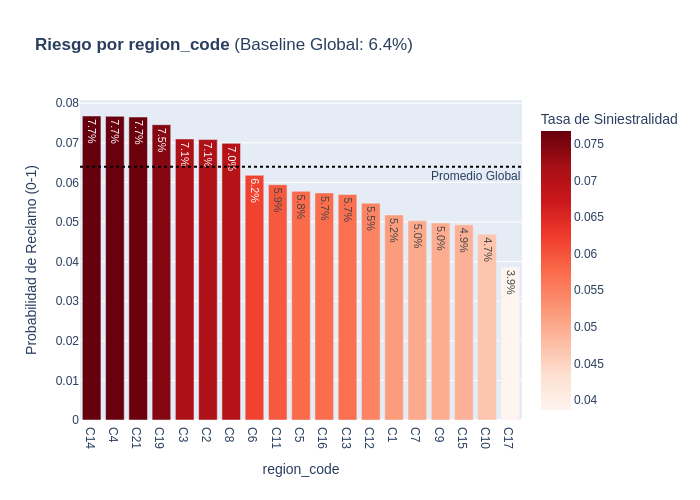

In [22]:
cats_to_analyze = [ 'region_code'] # 'segment', 'fuel_type', 'ncap_rating',

# Creación subplots
for cat in cats_to_analyze:
    if cat not in df.columns: continue

    # Agrupación
    risk_profile = df.groupby(cat)['claim_status'].agg(['mean', 'count']).reset_index()
    risk_profile.columns = [cat, 'claim_rate', 'volume']

    # Filtro

    min_vol = len(df) * 0.005
    risk_profile = risk_profile[risk_profile['volume'] > min_vol].sort_values('claim_rate', ascending=False)

    # Gráfico de Barras
    fig = px.bar(
        risk_profile,
        x=cat,
        y='claim_rate',
        color='claim_rate',
        title=f"<b>Riesgo por {cat}</b> (Baseline Global: {baseline_rate:.1%})",
        labels={'claim_rate': 'Tasa de Siniestralidad'},
        color_continuous_scale='Reds',
        text_auto='.1%'
    )

    # Línea de Referencia
    fig.add_hline(
        y=baseline_rate,
        line_dash="dot",
        line_color="black",
        annotation_text="Promedio Global",
        annotation_position="bottom right"
    )

    fig.update_layout(yaxis_title="Probabilidad de Reclamo (0-1)", showlegend=False)
    fig.show()

Esto se puede observar con más detalle en esta gráfica, que calcula el porcentaje de siniestralidad por región y lo contrasta con la siniestralidad global.

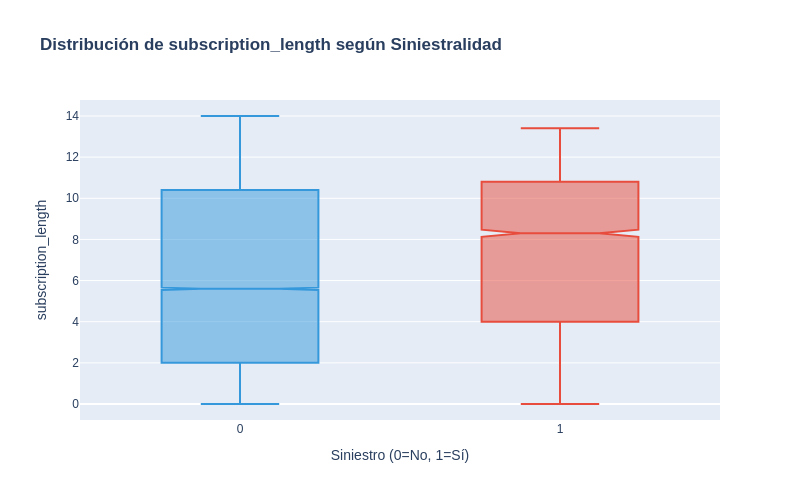

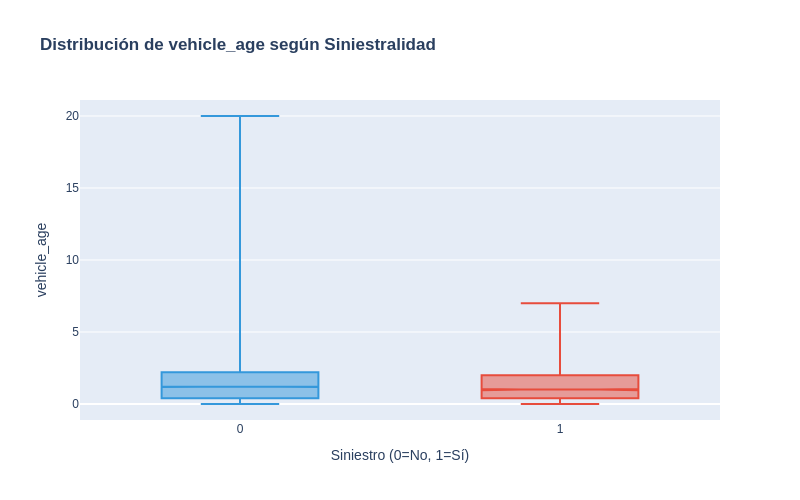

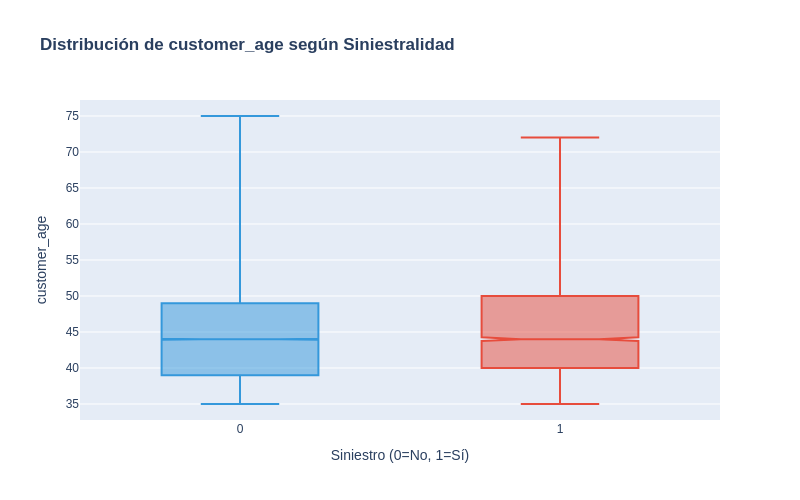

In [23]:
# Lista de numéricas clave a "interrogar" contra el Target
target_vars = ['subscription_length','vehicle_age', 'customer_age']
# Filtro
target_vars = [v for v in target_vars if v in df.columns]

# ==============================================================================
# ENFOQUE 1: BOXPLOTS (Diferencia de Medias y Dispersión)
# ==============================================================================


for var in target_vars:
    fig = px.box(
        df,
        x='claim_status',
        y=var,
        color='claim_status',
        title=f"<b>Distribución de {var} según Siniestralidad</b>",
        labels={'claim_status': 'Siniestro (0=No, 1=Sí)'},
        color_discrete_map={0: '#3498DB', 1: '#E74C3C'},
        notched=True,
        points=False
    )
    fig.update_layout(showlegend=False, width=800, height=500)
    fig.show()

Respecto a las variabkles numéricas se puede observar con curiosidad, que los vehiculos con subscription length con edad inferior a 4 años tienden a no presentar reclamaciones, demarcados por los cuartiles 1 al 3 de siniestralidad, esto permite evidenciar la diferencia en medidas cenbtrales que permite observar esta ligera correlación.

# Análisis grafico variables completas

In [25]:
def plot_univariate_portfolio(df, var, target="claim_status", nbins=30,
                              cat_mode="within"):
    """
    Visualización univariada lado a lado:
    - Izquierda: target = 0 (no siniestrado)
    - Derecha: target = 1 (siniestrado)

    Numéricas: histogramas con histnorm='percent'.
    Categóricas/binarias: barras con tres opciones de y:
        cat_mode = 'within' -> % dentro de cada grupo de target
        cat_mode = 'global' -> % del total del portafolio
        cat_mode = 'count'  -> número de pólizas
    """
    if var not in df.columns:
        raise ValueError(f"{var} no está en df.columns")
    if target not in df.columns:
        raise ValueError(f"{target} no está en df.columns")

    data = df[[var, target]].copy().dropna(subset=[var, target])

    # Ordenar target 0,1 si es binario
    if data[target].nunique() == 2 and set(data[target].unique()) == {0, 1}:
        data[target] = data[target].astype(int)
        category_orders = {target: [0, 1]}
    else:
        category_orders = None

    # ----------------- Caso numérico -----------------
    if is_numeric_dtype(data[var]):
        fig = px.histogram(
            data,
            x=var,
            facet_col=target,
            histnorm="percent",   # % dentro de cada panel
            nbins=nbins,
            opacity=0.8,
            category_orders=category_orders,
            title=f"Distribución de {var}: no siniestrado (izq) vs siniestrado (der)",
        )
        fig.for_each_annotation(lambda a: a.update(text=a.text.replace(target + "=", "")))
        fig.update_layout(xaxis_title=var, yaxis_title="% dentro del grupo de " + target)
        fig.show()
        return

    # ----------------- Caso categórico/binario -----------------

    agg = (
        data
        .groupby([target, var])
        .size()
        .reset_index(name="n")
    )

    # % sobre todo el portafolio
    total_n = len(data)
    agg["pct_total"] = agg["n"] / total_n * 100

    # % dentro de cada grupo de target
    agg["pct_within_target"] = (
        agg["n"] / agg.groupby(target)["n"].transform("sum") * 100
    )

    # métrica de y
    if cat_mode == "within":
        y_col = "pct_within_target"
        y_title = f"% dentro de cada grupo de {target}"
    elif cat_mode == "global":
        y_col = "pct_total"
        y_title = "% del total del portafolio"
    elif cat_mode == "count":
        y_col = "n"
        y_title = "Número de pólizas"
    else:
        raise ValueError("cat_mode debe ser 'within', 'global' o 'count'")

    fig = px.bar(
        agg,
        x=var,
        y=y_col,
        facet_col=target,
        category_orders=category_orders,
        title=f"Composición de {var}: no siniestrado (izq) vs siniestrado (der) — {y_title}",
        hover_data=["n", "pct_total", "pct_within_target"],
    )
    fig.for_each_annotation(lambda a: a.update(text=a.text.replace(target + "=", "")))
    fig.update_layout(xaxis_tickangle=-45, yaxis_title=y_title)
    fig.show()

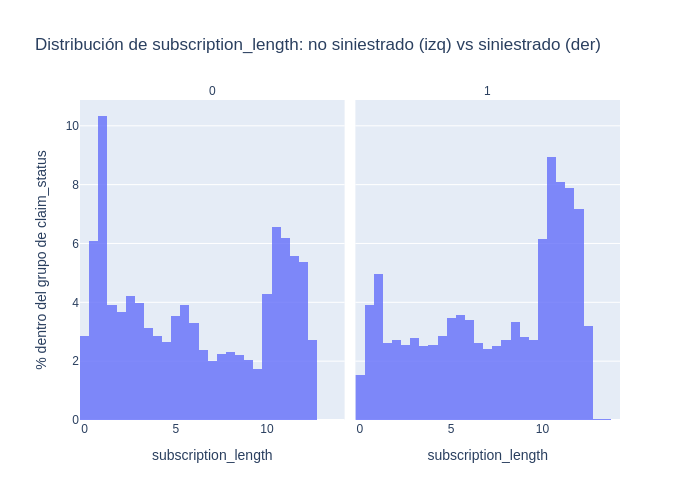

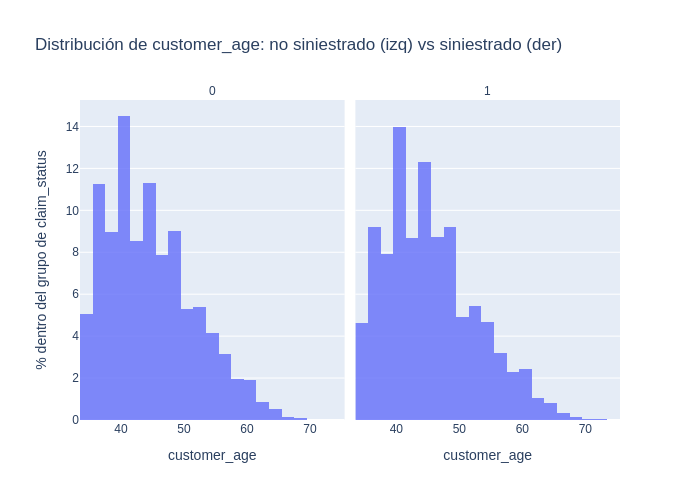

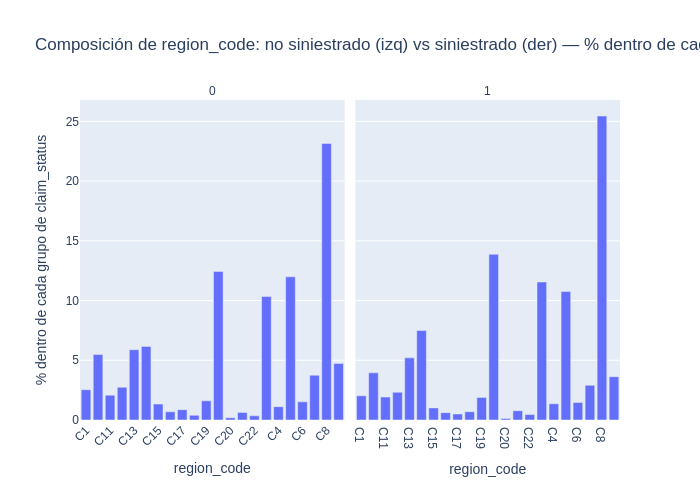

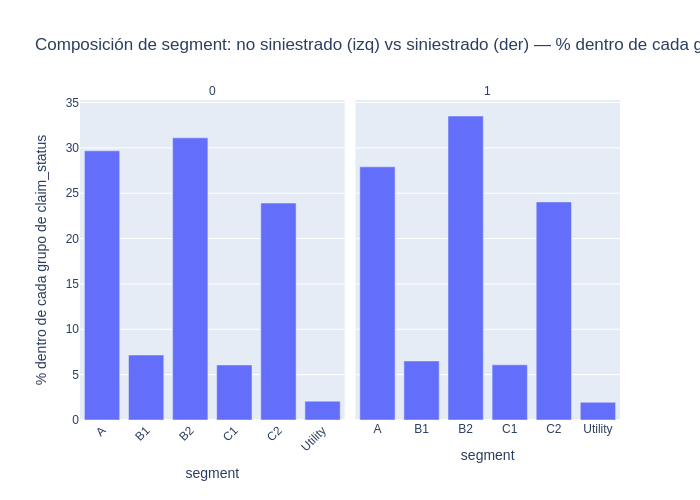

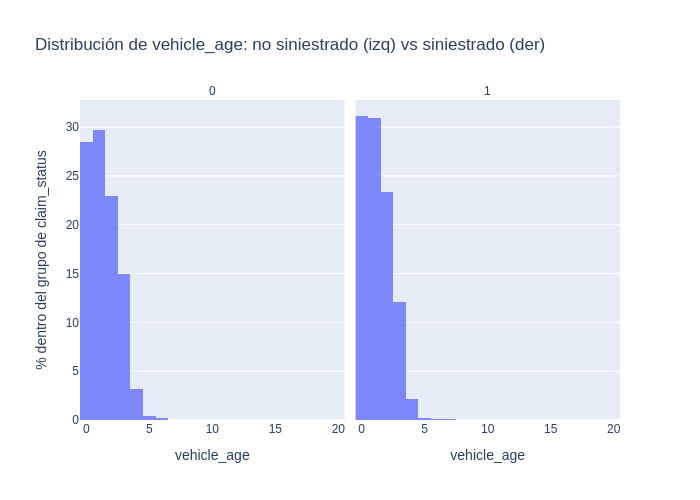

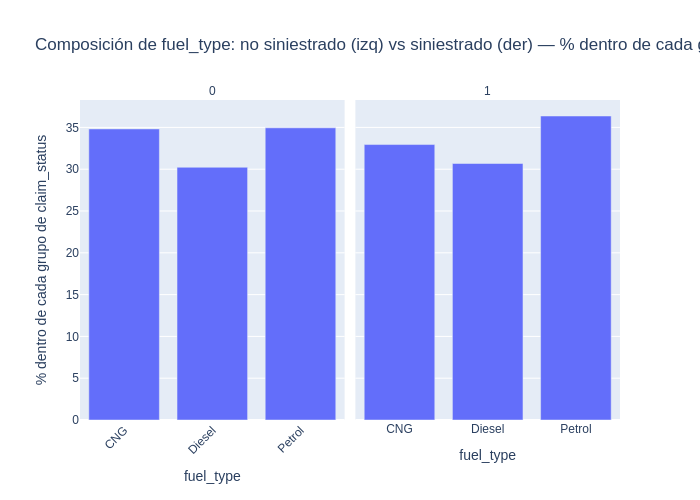

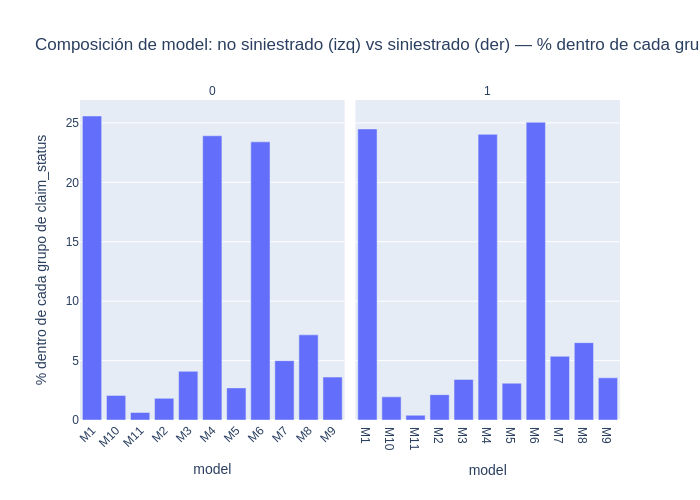

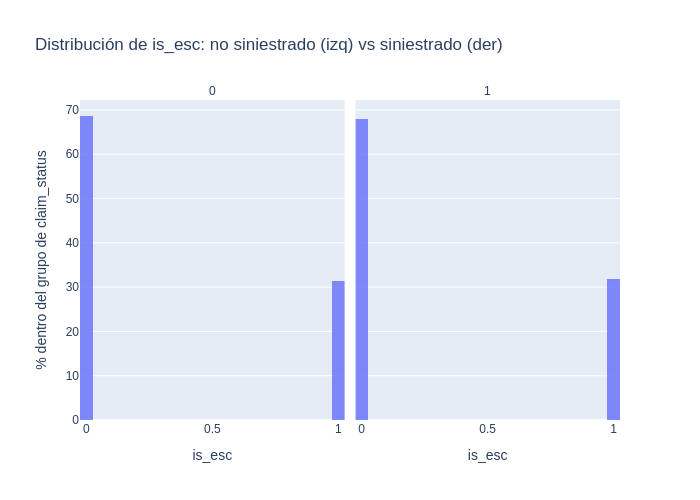

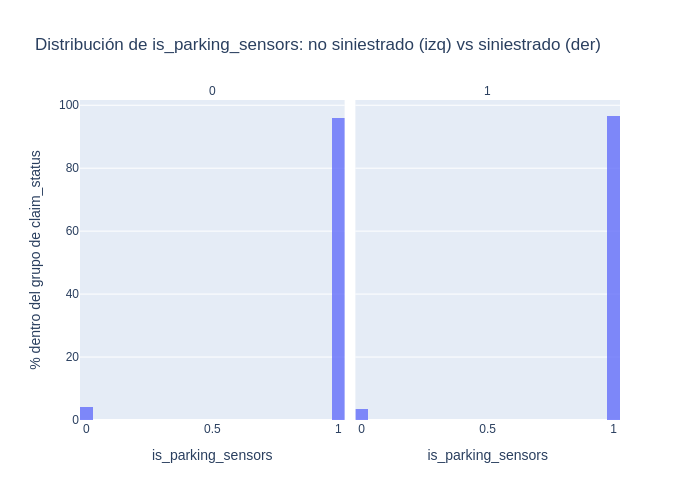

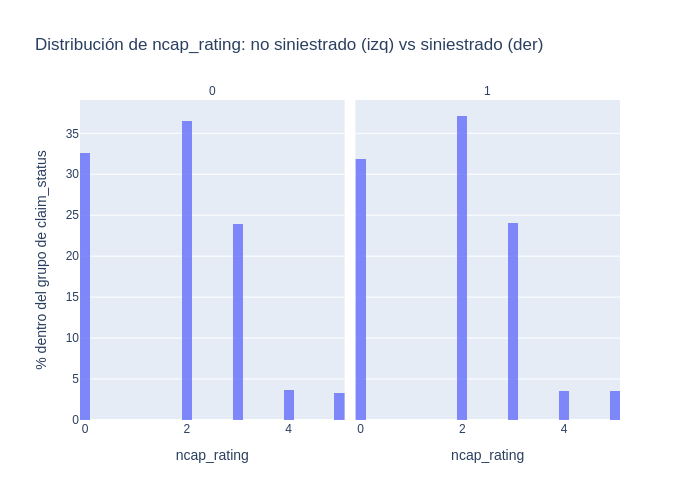

In [26]:

# Variables de cliente
plot_univariate_portfolio(df, "subscription_length")
plot_univariate_portfolio(df, "customer_age")
plot_univariate_portfolio(df, "region_code")
plot_univariate_portfolio(df, "segment")

# Variables de vehículo
plot_univariate_portfolio(df, "vehicle_age")
plot_univariate_portfolio(df, "fuel_type")
plot_univariate_portfolio(df, "model")

# Variables de seguridad (binarias y rating)
plot_univariate_portfolio(df, "is_esc")
plot_univariate_portfolio(df, "is_parking_sensors")
plot_univariate_portfolio(df, "ncap_rating")


Podemos observar que la diferencia de distribución en las demás variables es minima, lo que refuerza junto con el análisis correlacional confirman el debíl poder predictivo de las demás variables

# Conclusiones

El portafolio está fuertemente desbalanceado: solo alrededor del 6,4% de las pólizas presenta reclamo, por lo que cualquier modelo deberá tratar explícitamente este desbalance (por ejemplo, mediante técnicas de re muestreo).
​

Las distribuciones de edades de cliente y vehículo, dimensiones físicas, potencia y niveles de seguridad son coherentes con una cartera de autos compactos y medianos, sin valores extremos que comprometan el uso del dataset.

El EDA muestra una alta concentración en ciertas regiones, segmentos, modelos y tipos de motor, así como diferencias claras de siniestralidad entre regiones y segmentos específicos.

La matriz Phi‑K indica que la relación de cada variable individual con claim_status es en general inexistente o débil (por ejemplo, subscription_length, edad del cliente, edad del vehículo y variables de seguridad), lo que sugiere que el poder predictivo de existir, vendrá de combinaciones e interacciones entre múltiples características más que de un único factor dominante.